# Imports

Data paths to modify (where data files should be saved)

In [1]:
STOP_DATA_DIR = "/home/guillaume/Documents/OpenData/Switzerland_transport/BAV_Liste/"
TIME_DATA_DIR = "/home/guillaume/Documents/OpenData/Switzerland_transport/Actual_data/"

Plot path to modify (where figures are saved)

In [2]:
PLOT_DIR = "plots/real_data/"

Automatic re-import upon source changes

In [3]:
%load_ext autoreload
%autoreload 2

Imports

In [4]:
import itertools
import os

from ipywidgets import interact, interact_manual, fixed
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [5]:
from src import *

Plot config

In [6]:
%matplotlib inline

Random seed (should be unnecessary)

In [7]:
np.random.seed(63)

# Downloading / reading the data

## Stops data

Source: https://opentransportdata.swiss/en/dataset/bav_liste

In [8]:
stops_path = STOP_DATA_DIR + "stops.parquet"

In [9]:
download_stops_data(STOP_DATA_DIR + "stops.xlsx")

In [10]:
stops = read_stops_data(STOP_DATA_DIR + "stops.xlsx")

Computing latitude :   0%|          | 0/28757 [00:00<?, ?it/s]

Computing longitude :   0%|          | 0/28757 [00:00<?, ?it/s]

In [11]:
stops.to_parquet(stops_path)

In [12]:
stops = pd.read_parquet(stops_path)

## Time data

Before executing the next cells:
1. Go to https://drive.google.com/drive/folders/1SVa68nJJRL3qgRSPKcXY7KuPN9MuHVhJ and download each monthly zip archive from 2018-2019 into `{TIME_DATA_DIR}/monthly_zip`.
2. Create empty folders named `{TIME_DATA_DIR}/parquet_daily` and `{TIME_DATA_DIR}/parquet_monthly`.

In [13]:
MONTHLY_ZIP_DIR_PATH = TIME_DATA_DIR + "monthly_zip"
DAILY_PARQUET_DIR_PATH = TIME_DATA_DIR + "parquet_daily"
MONTHLY_PARQUET_DIR_PATH = TIME_DATA_DIR + "parquet_monthly"

Beware: the following cell can take several hours to run.

In [14]:
# unzip_months_store_days(MONTHLY_ZIP_DIR_PATH, DAILY_PARQUET_DIR_PATH)
# read_days_store_months(DAILY_PARQUET_DIR_PATH, MONTHLY_PARQUET_DIR_PATH)

In [15]:
data = read_months_return_full(MONTHLY_PARQUET_DIR_PATH, years=[2018, 2019])

Reading files :   0%|          | 0/24 [00:00<?, ?it/s]

Concatenation :   0%|          | 0/21 [00:00<?, ?it/s]

# Preprocessing

In [16]:
data.dtypes

date                      datetime64[ns]
trip_id                         category
agency_id                       category
agency_short_name               category
agency_name                     category
transportation_type             category
line_id                         category
line_name                       category
circuit_transfer                category
transportation_subtype          category
unplanned_trip                  category
cancelled_trip                  category
stop_id                         category
stop_name_unofficial            category
arrival_time_planned      datetime64[ns]
arrival_time_real         datetime64[ns]
arrival_time_status             category
departure_time_planned    datetime64[ns]
departure_time_real       datetime64[ns]
departure_time_status           category
skipped_stop                    category
dtype: object

Drop the columns we won't use

In [17]:
data = drop_useless_columns(data)

Uncategorize categorical variables for future group-bys

In [18]:
data = uncategorize(data)

Remove skipped or unplanned stops and cancelled trips

In [19]:
data = remove_skipped_unplanned_cancelled(data)

Select the event types we want

In [20]:
data = keep_only_arrivals(data)

# EDA and cleaning

In [21]:
data.dtypes

date                  datetime64[ns]
trip_id                       string
line_name                     string
stop_id                       string
event_time_planned    datetime64[ns]
event_time_real       datetime64[ns]
event_time_status           category
dtype: object

## Data quantity

Size

In [22]:
data.shape

(63477101, 7)

In [23]:
data.memory_usage() / 1e9

Index                 0.507817
date                  0.507817
trip_id               0.507817
line_name             0.507817
stop_id               0.507817
event_time_planned    0.507817
event_time_real       0.507817
event_time_status     0.063477
dtype: float64

In [24]:
data.memory_usage().sum() / 1e9

3.618194961

Month heterogeneity

In [25]:
months_since_start = 12*(data["date"].dt.year-2018) + data["date"].dt.month
month_freq = data.groupby(months_since_start).size()

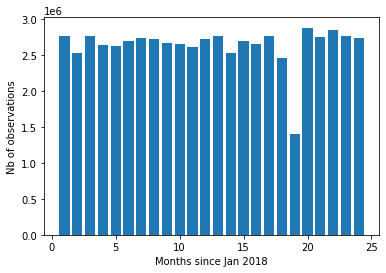

In [26]:
plt.close()
plt.bar(month_freq.index, month_freq)
plt.xlabel("Months since Jan 2018")
plt.ylabel("Nb of observations")
plt.savefig(PLOT_DIR + "month_freq.pdf")
plt.show()

In [27]:
normal_months = month_freq[
    month_freq > 0.75*month_freq.median()
].index.tolist()

is_normal_month = months_since_start.isin(normal_months)

In [28]:
is_normal_month.mean()

0.9778953200777081

Weekday heterogeneity

In [29]:
weekday_freq = data.groupby(
    data["date"].dt.weekday
).size()

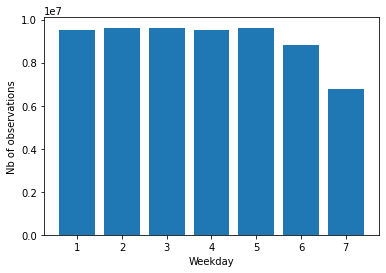

In [30]:
plt.close()
plt.bar(weekday_freq.index + 1, weekday_freq)
plt.xlabel("Weekday")
plt.ylabel("Nb of observations")
plt.savefig(PLOT_DIR + "weekday_freq.pdf")
plt.show()

In [31]:
is_weekday = data["date"].dt.weekday <= 4

In [32]:
is_weekday.mean()

0.7544769097126852

Hour heterogeneity

In [33]:
hour_freq = data.groupby(
    data["event_time_planned"].dt.hour
).size()

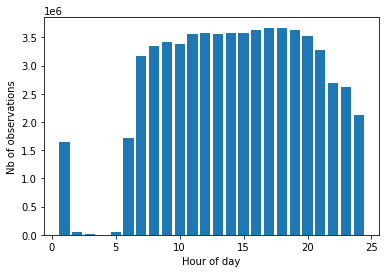

In [34]:
plt.close()
plt.bar(hour_freq.index + 1, hour_freq)
plt.xlabel("Hour of day")
plt.ylabel("Nb of observations")
plt.savefig(PLOT_DIR + "hour_freq.pdf")
plt.show()

In [35]:
is_evening_peak = (
    (17 <= data["event_time_planned"].dt.hour)
    & (data["event_time_planned"].dt.hour <= 19)
)

In [36]:
is_evening_peak.mean()

0.17060785431899292

Restrict dataset to a coherent subset in terms of data quantity

In [37]:
data = data[is_normal_month & is_weekday & is_evening_peak]

Is there still date heterogeneity?

In [38]:
date_freq = data.groupby(
    data["date"].dt.date
).size()

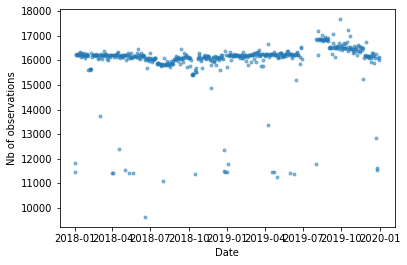

In [39]:
plt.close()
plt.scatter(date_freq.index, date_freq, alpha=0.5, marker=".")
plt.xlabel("Date")
plt.ylabel("Nb of observations")
plt.savefig(PLOT_DIR + "date_freq.pdf")
plt.show()

In [40]:
normal_dates = date_freq[
    (date_freq > 0.75*date_freq.median())
    & (date_freq < 1.25*date_freq.median())
].index.tolist()

In [41]:
is_normal_date = data["date"].isin(normal_dates)

In [42]:
is_normal_date.mean()

0.9683168236741094

In [43]:
data = data[is_normal_date]

New data size

In [44]:
data.shape

(7661161, 7)

In [45]:
data.memory_usage().sum() / 1e9

0.436686381

## Data quality

Add next trip event in each row to allow for edge analysis

In [46]:
data = add_next_event(data)

Remove self-loops

In [47]:
data = data[data["stop_id"].values != data["next_stop_id"].values]

Add edge duration and delay columns

In [48]:
data = add_delay_columns(data)

Analyze edge durations

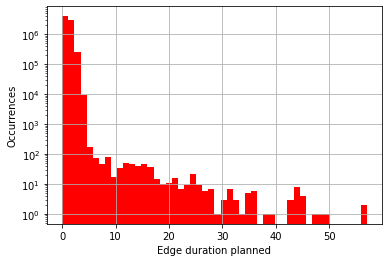

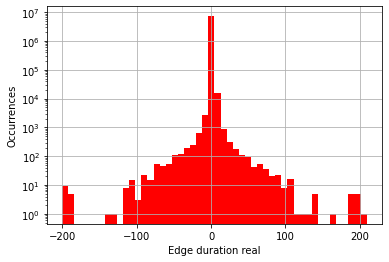

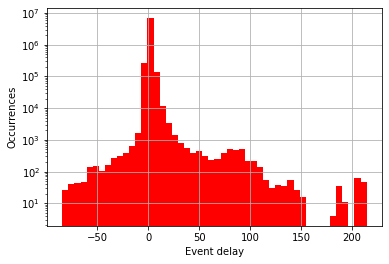

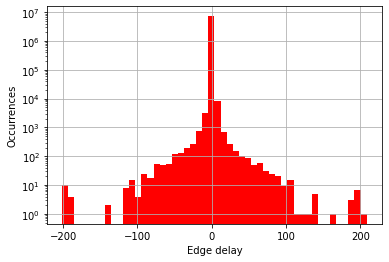

In [49]:
for col in [
    "edge_duration_planned",
    "edge_duration_real",
    "event_delay",
    "edge_delay",
]:
    plt.close()
    plt.yscale("log")
    data[col].hist(bins=50, color="red")
    plt.ylabel("Occurrences")
    plt.xlabel(col.replace("_", " ").capitalize())
    plt.savefig(PLOT_DIR + "histogram_nocleaning_{}.pdf".format(col))
    plt.show()

Remove outliers

In [50]:
filtered_data = remove_outliers_delays(
    data,
    min_edge_duration_planned=0,
    max_edge_duration_planned=10,
    min_edge_duration_real=-np.inf,
    max_edge_duration_real=np.inf,
    min_edge_delay=-2,
    max_edge_delay=10,
    min_event_delay=-10,
    max_event_delay=30,
)

In [51]:
data.shape, filtered_data.shape

((7257119, 15), (7236690, 15))

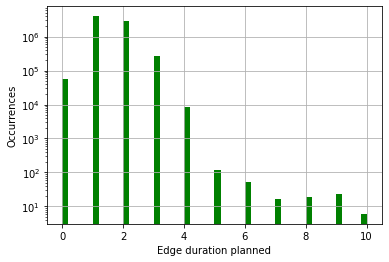

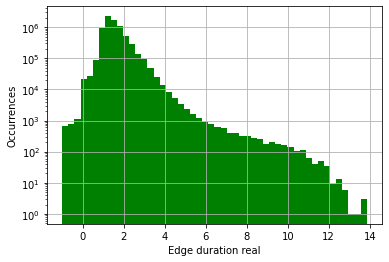

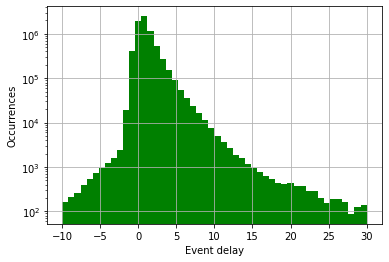

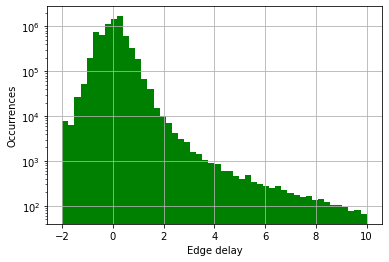

In [52]:
for col in [
    "edge_duration_planned",
    "edge_duration_real",
    "event_delay",
    "edge_delay",
]:
    plt.close()
    plt.yscale("log")
    filtered_data[col].hist(color="green", bins=50)
    plt.ylabel("Occurrences")
    plt.xlabel(col.replace("_", " ").capitalize())
    plt.savefig(PLOT_DIR + "histogram_aftercleaning_{}.pdf".format(col))
    plt.show()

In [53]:
data = filtered_data

## Network

In [54]:
data.groupby("stop_id").size().shape

(205,)

In [55]:
data.groupby(["stop_id", "next_stop_id"]).size().shape

(2595,)

In [56]:
G = build_network(data, stops, max_edge_rank=200)

In [57]:
G.number_of_nodes(), G.number_of_edges()

(78, 163)

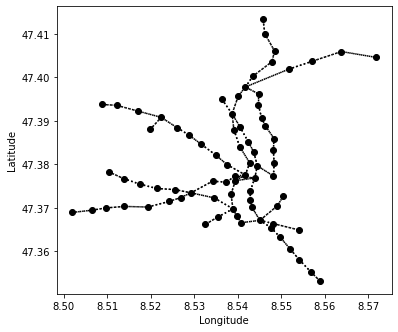

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_network(G, ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.axis("scaled")
plt.savefig(PLOT_DIR + "map_zurich.pdf")

Define edge ids

In [59]:
edge_ids = pd.Series(
    index=pd.MultiIndex.from_tuples(list(G.edges)),
    data=np.arange(G.number_of_edges()),
    name="edge_id",
    dtype="Int64"
)

Add ids to graph and data

In [60]:
for stop_id, next_stop_id in edge_ids.index:
    G.edges[stop_id, next_stop_id]["edge_id"] = edge_ids[(stop_id, next_stop_id)]

In [61]:
data = data.join(edge_ids, on=("stop_id", "next_stop_id"))
data = data[data["edge_id"].notnull()]

In [62]:
data.shape

(4109324, 16)

## Centering

In [63]:
edge_delay_center = data.groupby("edge_id")["edge_delay"].mean()
edge_delay_center.name = "edge_delay_center"

In [64]:
data = data.join(edge_delay_center, on="edge_id")
data["centered_edge_delay"] = data["edge_delay"] - data["edge_delay_center"]

# Transition estimation

In [65]:
map_network(G)

In [66]:
%matplotlib notebook

<IPython.core.display.Javascript object>


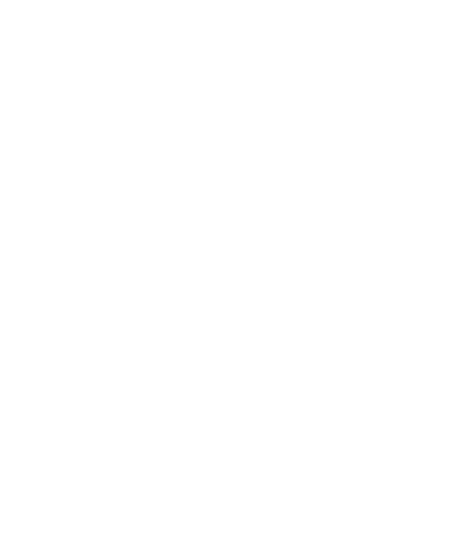

interactive(children=(IntSlider(value=5, description='freq', max=10, min=1), FloatSlider(value=-2.0, descripti…

<function src.plotting.estimate_transition_and_plot(data, freq, log_lambda0, G, log_weight_threshold, ax)>

In [67]:
plt.close()
fig, ax = plt.subplots(figsize=(6, 7))
interact_manual(
    estimate_transition_and_plot,
    data=fixed(data),
    h0=fixed(0),
    freq=(1, 10, 1),
    log_lambda0=(-3, 0, 0.01),
    log_weight_threshold=(-2, 0, 0.1),
    G=fixed(G),
    ax=fixed(ax),
    continuous_update=False
)

In [68]:
%matplotlib inline

In [69]:
lambda0_range = np.logspace(-2, 0, 100)
freq_range = [1, 2, 3, 5, 7, 10, 15]

In [70]:
dist = get_distance_matrix(G)

In [72]:
thetas_by_freq = {}

for freq in freq_range:
    thetas = estimate_transition(
        data=data, freq=freq, lambda0_range=lambda0_range
    )
    thetas_by_freq[freq] = thetas

Estimating theta:   0%|          | 0/163 [00:00<?, ?it/s]

Estimating theta:   0%|          | 0/163 [00:00<?, ?it/s]

Estimating theta:   0%|          | 0/163 [00:00<?, ?it/s]

Estimating theta:   0%|          | 0/163 [00:00<?, ?it/s]

Estimating theta:   0%|          | 0/163 [00:00<?, ?it/s]

Estimating theta:   0%|          | 0/163 [00:00<?, ?it/s]

Estimating theta:   0%|          | 0/163 [00:00<?, ?it/s]

In [74]:
mean_interac_dists_by_freq = {}
densities_by_freq = {}

for freq in freq_range:
    mean_interac_dists_by_freq[freq] = np.array([
        np.sum((np.abs(theta) * dist)[np.abs(theta) > 1e-2]) /
        np.sum(np.abs(theta)[np.abs(theta) > 1e-2]) for theta in thetas_by_freq[freq]
    ])
    densities_by_freq[freq] = np.array([
        np.sum(np.abs(theta) > 1e-2) / theta.shape[0] for theta in thetas_by_freq[freq]
    ])

<ipython-input-74-2fe35d435681>:6: RuntimeWarning: invalid value encountered in double_scalars
  np.sum((np.abs(theta) * dist)[np.abs(theta) > 1e-2]) /


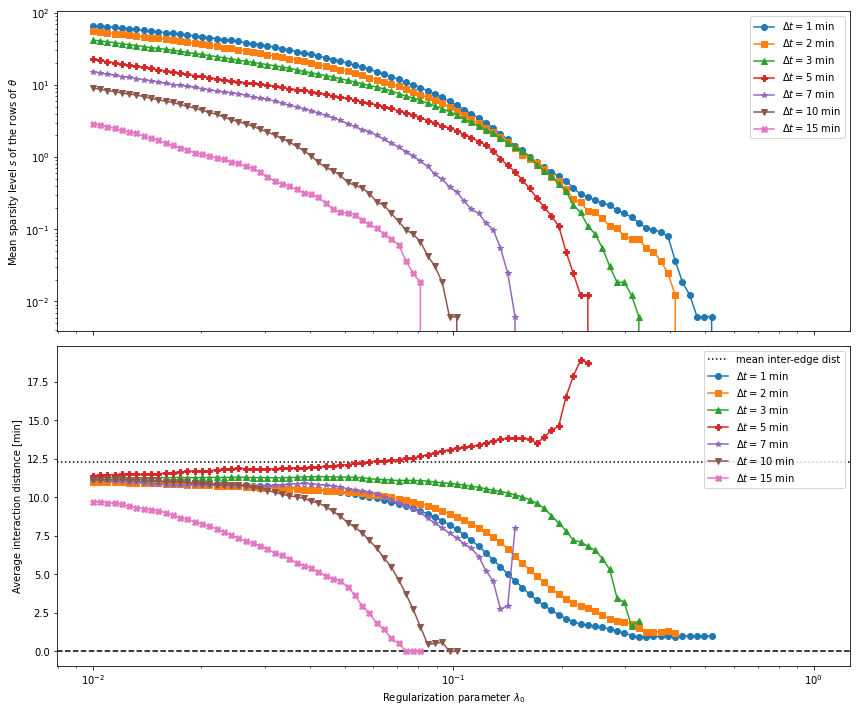

In [78]:
plt.close()
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 10))

ax[1].axhline(y=0, color="k", linestyle="dashed")
ax[0].axhline(y=0, color="k", linestyle="dashed")

ax[1].axhline(y=dist.mean(), color="k", label="mean inter-edge dist", linestyle="dotted")

for (k, freq) in enumerate(freq_range):
    ax[0].plot(
        lambda0_range, densities_by_freq[freq],
        label="$\\Delta t = {}$ min".format(freq),
        marker=MARKERS[k]
    )
    ax[1].plot(
        lambda0_range, mean_interac_dists_by_freq[freq],
        label="$\\Delta t = {}$ min".format(freq),
        marker=MARKERS[k]
    )

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylabel("Mean sparsity level $s$ of the rows of $\\theta$")
ax[0].legend()

ax[1].set_xscale("log")
ax[1].set_ylabel("Average interaction distance [min]")
ax[1].set_xlabel("Regularization parameter $\\lambda_0$")
ax[1].legend()

plt.tight_layout()
plt.savefig(PLOT_DIR + "regularization_effect.pdf")
plt.show()

In [79]:
data["edge_duration_planned"].mean()

1.5226974